# MLOps Pipeline Workflow & Team Notes

## Project Overview
This notebook implements an end-to-end MLOps data pipeline using the **Olist Brazilian E-Commerce dataset**. The goal was to demonstrate a production-style workflow that covers data ingestion, cataloging, exploratory analysis, feature engineering, feature storage, and dataset splitting — all using AWS services in a cost-efficient way.

The pipeline was intentionally built step-by-step to mirror MLOps practices rather than a one-off modeling notebook.


In [1]:
# Import
import os, json, time, zipfile, glob, random
from pathlib import Path
import pandas as pd
import numpy as np

import boto3
import botocore

# Plotting
import matplotlib.pyplot as plt


In [ ]:
# Install required packages if not already present
# %pip install awswrangler sagemaker kaggle


### Library Verification
Ensuring that the required libraries (`awswrangler` and `sagemaker`) are installed and available in the environment.


In [2]:
import importlib
def ensure(pkg):
    try:
        importlib.import_module(pkg)
        return True
    except Exception as e:
        print(f"Package '{pkg}' not available yet: {e}")
        return False

has_wr = ensure("awswrangler")
has_sm = ensure("sagemaker")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


### Configuration
Setting up SageMaker session, default bucket, and S3 prefixes.


In [3]:
#Configure 
import sagemaker

sess = sagemaker.Session()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity()["Account"]

# Use default SageMaker bucket 
default_bucket = sess.default_bucket()

# If your class provides a specific bucket, set it here
DATALAKE_BUCKET = os.environ.get("DATALAKE_BUCKET", default_bucket)

# S3 prefixes 
RAW_PREFIX = "datalake/olist/raw/"
FEATURE_PREFIX = "datalake/olist/features/"
SPLITS_PREFIX = "datalake/olist/splits/"

# Athena 
ATHENA_DB = "olist_datalake"
ATHENA_OUTPUT = f"s3://{DATALAKE_BUCKET}/athena-results/"   

print("Region:", region)
print("Account:", account_id)
print("Datalake bucket:", DATALAKE_BUCKET)
print("Athena output:", ATHENA_OUTPUT)

Region: us-east-1
Account: 638321960078
Datalake bucket: sagemaker-us-east-1-638321960078
Athena output: s3://sagemaker-us-east-1-638321960078/athena-results/


### 1. Raw Data Ingestion (S3 Data Lake)
- Created an S3 bucket to act as a data lake.
- Uploaded all **9 raw CSV files** from the Kaggle Olist dataset.
- Organized raw data under: s3:///raw/olist/ingest_date=YYYY-MM-DD/
- Each dataset was placed into its own subfolder to support Athena’s directory-based table requirements.


In [4]:
import shutil, subprocess, sys
from pathlib import Path
import os, zipfile

# Ensure Kaggle CLI is installed 
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "kaggle"])

# Find the kaggle executable
kaggle_exe = shutil.which("kaggle")
if kaggle_exe is None:
    alt = str(Path.home() / ".local" / "bin" / "kaggle")
    kaggle_exe = alt if Path(alt).exists() else None

if kaggle_exe is None:
    raise RuntimeError("Kaggle CLI not found on PATH after install. Try restarting the kernel.")

print("Using Kaggle CLI:", kaggle_exe)

# Download dataset
KAGGLE_DATASET = "olistbr/brazilian-ecommerce"
DOWNLOAD_DIR = Path.cwd() / "kaggle_download"
EXTRACT_DIR = Path.cwd() / "olist_raw"
DOWNLOAD_DIR.mkdir(exist_ok=True, parents=True)
EXTRACT_DIR.mkdir(exist_ok=True, parents=True)

# Download
subprocess.check_call([
    kaggle_exe, "datasets", "download",
    "-d", KAGGLE_DATASET,
    "-p", str(DOWNLOAD_DIR),
    "--force"
])

# Pick the latest zip
zips = sorted(DOWNLOAD_DIR.glob("*.zip"), key=lambda p: p.stat().st_mtime, reverse=True)
if not zips:
    raise FileNotFoundError("No zip was downloaded. Check kaggle.json permissions and dataset name.")

zip_path = zips[0]
print("Downloaded ZIP:", zip_path)

# Extract
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(EXTRACT_DIR)

csvs = sorted(EXTRACT_DIR.glob("*.csv"))
print("CSV files found:", len(csvs))
for p in csvs[:20]:
    print(" -", p.name)


  Using cached kaggle-1.8.3-py3-none-any.whl.metadata (16 kB)
  Using cached kagglesdk-0.1.15-py3-none-any.whl.metadata (13 kB)
  Using cached mypy-1.19.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (2.2 kB)
  Using cached types_requests-2.32.4.20260107-py3-none-any.whl.metadata (2.0 kB)
  Using cached types_tqdm-4.67.0.20250809-py3-none-any.whl.metadata (1.7 kB)
  Using cached librt-0.7.8-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (1.3 kB)
  Using cached urllib3-2.6.3-py3-none-any.whl.metadata (6.9 kB)
Using cached kaggle-1.8.3-py3-none-any.whl (102 kB)
Using cached kagglesdk-0.1.15-py3-none-any.whl (160 kB)
Using cached mypy-1.19.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (13.6 MB)
Using cached librt-0.7.8-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (192 kB)
Using cached types_requests-2.32.4.20260107-py3-none-any.wh

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-studio 1.1.4 requires pydynamodb>=0.7.4, which is not installed.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.3.3 which is incompatible.


Using Kaggle CLI: /opt/conda/bin/kaggle
Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0


100%|██████████| 42.6M/42.6M [00:00<00:00, 112MB/s] 



Downloaded ZIP: /home/sagemaker-user/aai-540-labs/lab-2-1-setting-up-a-datalake-in-aws/02_setup_datalake/kaggle_download/brazilian-ecommerce.zip
CSV files found: 9
 - olist_customers_dataset.csv
 - olist_geolocation_dataset.csv
 - olist_order_items_dataset.csv
 - olist_order_payments_dataset.csv
 - olist_order_reviews_dataset.csv
 - olist_orders_dataset.csv
 - olist_products_dataset.csv
 - olist_sellers_dataset.csv
 - product_category_name_translation.csv


### Upload to S3
Uploading raw CSV files to the S3 bucket to create the Data Lake layer.


In [5]:
# Upload to S3 Data Lake
s3 = boto3.client("s3")

def s3_put_file(local_path: Path, bucket: str, key: str):
    s3.upload_file(str(local_path), bucket, key)

csvs = sorted(EXTRACT_DIR.glob("*.csv"))
if not csvs:
    raise RuntimeError("No CSVs found. Ensure the dataset was extracted correctly.")

# Check if raw data already exists (Cost Savings)
existing = s3.list_objects_v2(Bucket=DATALAKE_BUCKET, Prefix=RAW_PREFIX)
if existing.get("KeyCount", 0) >= len(csvs):
    print("✅ Raw data found in S3. Skipping upload to prevent redundant costs.")
    print(f"Location: s3://{DATALAKE_BUCKET}/{RAW_PREFIX}")
else:
    print(f"Uploading {len(csvs)} files to s3://{DATALAKE_BUCKET}/{RAW_PREFIX} ...")
    for p in csvs:
        key = RAW_PREFIX + p.name
        s3_put_file(p, DATALAKE_BUCKET, key)
        print("Uploaded:", f"s3://{DATALAKE_BUCKET}/{key}")

RAW_S3_URI = f"s3://{DATALAKE_BUCKET}/{RAW_PREFIX}"
print("\nRaw data lake prefix:", RAW_S3_URI)


Uploaded: s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_customers_dataset.csv
Uploaded: s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_geolocation_dataset.csv
Uploaded: s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_order_items_dataset.csv
Uploaded: s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_order_payments_dataset.csv
Uploaded: s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_order_reviews_dataset.csv
Uploaded: s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_orders_dataset.csv
Uploaded: s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_products_dataset.csv
Uploaded: s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_sellers_dataset.csv
Uploaded: s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/product_category_name_translation.csv

Raw data lake prefix: s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/


### Organize Raw Data
Copying files into Hive-style partition folders to support Athena cataloging.


In [6]:
# Copy each raw CSV into its own table folder 
import awswrangler as wr
from pathlib import Path

for local_csv in csvs:
    table_name = local_csv.stem.replace("-", "_").replace(" ", "_").lower()

    src = f"s3://{DATALAKE_BUCKET}/{RAW_PREFIX}{local_csv.name}"
    dst_dir = f"s3://{DATALAKE_BUCKET}/{RAW_PREFIX}{table_name}/"
    dst = f"{dst_dir}data.csv"

    wr.s3.copy_objects(
        paths=[src],
        source_path=src,
        target_path=dst
    )

    print("Copied:", src, "->", dst)


2026-01-25 19:06:04,651	WARNING services.py:2070 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 1938788352 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.57gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2026-01-25 19:06:05,904	INFO worker.py:1852 -- Started a local Ray instance.


Copied: s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_customers_dataset.csv -> s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_customers_dataset/data.csv
Copied: s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_geolocation_dataset.csv -> s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_geolocation_dataset/data.csv
Copied: s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_order_items_dataset.csv -> s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_order_items_dataset/data.csv
Copied: s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_order_payments_dataset.csv -> s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_order_payments_dataset/data.csv
Copied: s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_order_reviews_dataset.csv -> s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_order_reviews_dataset/data.csv
Copied: s3://sagemaker-us-east-1-63832196007

### 2. Data Cataloging & Querying (Athena)
- Created an Athena database (`olist_datalake`).
- Defined **external tables** for each dataset directly from JupyterLab (no Glue crawler required).
- Verified schemas and row counts using Athena queries.
- This step enabled SQL-based access to the data and served as the cataloging layer for downstream analysis.


In [7]:
# Create Athena Database and external tables
if not has_wr:
    raise ImportError(
        "awswrangler is required for the most convenient Athena/Glue table creation. "
        "Uncomment the pip install cell above and rerun."
    )

import awswrangler as wr
import boto3
from urllib.parse import urlparse

# Ensure Athena output prefix exists
parsed = urlparse(ATHENA_OUTPUT)
bucket = parsed.netloc
prefix = parsed.path.lstrip("/").rstrip("/") + "/"

s3 = boto3.client("s3")
s3.put_object(Bucket=bucket, Key=prefix)

# Create DB
wr.catalog.create_database(name=ATHENA_DB, exist_ok=True)
print("Database ready:", ATHENA_DB)

def infer_schema_from_csv(local_csv: Path, nrows=2000):
    df = pd.read_csv(local_csv, nrows=nrows)
    mapping = {}
    for col, dt in df.dtypes.items():
        if pd.api.types.is_integer_dtype(dt):
            mapping[col] = "bigint"
        elif pd.api.types.is_float_dtype(dt):
            mapping[col] = "double"
        elif pd.api.types.is_bool_dtype(dt):
            mapping[col] = "boolean"
        elif pd.api.types.is_datetime64_any_dtype(dt):
            mapping[col] = "timestamp"
        else:
            mapping[col] = "string"
    return mapping

created = []

for local_csv in csvs:
    table_name = local_csv.stem.replace("-", "_").replace(" ", "_").lower()
    table_dir = f"s3://{DATALAKE_BUCKET}/{RAW_PREFIX}{table_name}/"
    schema = infer_schema_from_csv(local_csv)

    # Delete table if it already exists (overwrite behavior)
    try:
        wr.catalog.delete_table_if_exists(database=ATHENA_DB, table=table_name)
    except Exception as e:
        print("Wrangler delete_table_if_exists not available or failed:", type(e).__name__, e)

    # Create table (points at folder)
    wr.catalog.create_csv_table(
        database=ATHENA_DB,
        table=table_name,
        path=table_dir,
        columns_types=schema,
        sep=",",
        skip_header_line_count=1,
        serde_library="org.apache.hadoop.hive.serde2.OpenCSVSerde",
        table_type="EXTERNAL_TABLE",
    )

    created.append(table_name)
    print("Created table:", table_name, "->", table_dir)

print("\nTables created:", created)



Database ready: olist_datalake
Created table: olist_customers_dataset -> s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_customers_dataset/
Created table: olist_geolocation_dataset -> s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_geolocation_dataset/
Created table: olist_order_items_dataset -> s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_order_items_dataset/
Created table: olist_order_payments_dataset -> s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_order_payments_dataset/
Created table: olist_order_reviews_dataset -> s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_order_reviews_dataset/
Created table: olist_orders_dataset -> s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_orders_dataset/
Created table: olist_products_dataset -> s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_products_dataset/
Created table: olist_sellers_dataset -> s3://sagemaker-us-east-1-638321960078/datal

### Verify Data Catalog
Running a simple SQL query to verify Athena tables are populated.


In [8]:
# Checkpoint: Pick a table to test
# Athena sanity check (row count)

test_table = "olist_orders_dataset"

sql = f"SELECT COUNT(*) AS n FROM {test_table}"

df_count = wr.athena.read_sql_query(
    sql=sql,
    database=ATHENA_DB,
    ctas_approach=False,
    s3_output=ATHENA_OUTPUT
)

df_count


,n
0,99441


### Checkpoint: Check what table Athena has


In [9]:
#Checkpoint: Check what table Athena has
import boto3

glue = boto3.client("glue")
resp = glue.get_tables(DatabaseName=ATHENA_DB)

table_names = sorted([t["Name"] for t in resp["TableList"]])
print("Glue tables:", len(table_names))
for n in table_names:
    print(" -", n)


Glue tables: 9
 - olist_customers_dataset
 - olist_geolocation_dataset
 - olist_order_items_dataset
 - olist_order_payments_dataset
 - olist_order_reviews_dataset
 - olist_orders_dataset
 - olist_products_dataset
 - olist_sellers_dataset
 - product_category_name_translation


### Checkpoint Check the S3 prefix has the csv objects


In [10]:
#Checkpoint Check the S3 prefix has the csv objects
import boto3
s3 = boto3.client("s3")

resp = s3.list_objects_v2(Bucket=DATALAKE_BUCKET, Prefix=RAW_PREFIX)
print("Found", resp.get("KeyCount", 0), "objects under", f"s3://{DATALAKE_BUCKET}/{RAW_PREFIX}")
for o in resp.get("Contents", [])[:25]:
    print(o["Key"])


Found 18 objects under s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/
datalake/olist/raw/olist_customers_dataset.csv
datalake/olist/raw/olist_customers_dataset/data.csv/sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_customers_dataset.csv
datalake/olist/raw/olist_geolocation_dataset.csv
datalake/olist/raw/olist_geolocation_dataset/data.csv/sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_geolocation_dataset.csv
datalake/olist/raw/olist_order_items_dataset.csv
datalake/olist/raw/olist_order_items_dataset/data.csv/sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_order_items_dataset.csv
datalake/olist/raw/olist_order_payments_dataset.csv
datalake/olist/raw/olist_order_payments_dataset/data.csv/sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_order_payments_dataset.csv
datalake/olist/raw/olist_order_reviews_dataset.csv
datalake/olist/raw/olist_order_reviews_dataset/data.csv/sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_order_revie

### Verify table location


In [12]:
#Verify table location
glue = boto3.client("glue")
tbl = glue.get_table(DatabaseName=ATHENA_DB, Name=test_table)
print(tbl["Table"]["StorageDescriptor"]["Location"])



s3://sagemaker-us-east-1-638321960078/datalake/olist/raw/olist_orders_dataset/


### 3. Exploratory Data Analysis (SageMaker + Pandas)
- Loaded Athena tables into Pandas using `awswrangler`.
- Performed sanity checks on row counts and joins.
- Built an **order-level analytical view** by aggregating items, payments, and customer attributes.
- Engineered a target variable (`is_late`).


In [13]:
#EDA
import awswrangler as wr

def read_raw_csv(name: str) -> pd.DataFrame:
    path = f"s3://{DATALAKE_BUCKET}/{RAW_PREFIX}{name}.csv"
    return wr.s3.read_csv(path)

orders = read_raw_csv("olist_orders_dataset")
items = read_raw_csv("olist_order_items_dataset")
payments = read_raw_csv("olist_order_payments_dataset")
reviews = read_raw_csv("olist_order_reviews_dataset")
customers = read_raw_csv("olist_customers_dataset")
products = read_raw_csv("olist_products_dataset")

print("orders:", orders.shape)
print("items:", items.shape)
print("payments:", payments.shape)
print("reviews:", reviews.shape)
print("customers:", customers.shape)
print("products:", products.shape)

orders.head()

orders: (99441, 8)
items: (112650, 7)
payments: (103886, 5)
reviews: (99224, 7)
customers: (99441, 5)
products: (32951, 9)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


### Data Quality Check
Checking for missing values in the datasets.


In [14]:
# Missing
def missing_report(df: pd.DataFrame, name: str, top=20):
    miss = df.isna().mean().sort_values(ascending=False).head(top)
    out = pd.DataFrame({"missing_pct": (miss*100).round(2), "column": miss.index})
    print(f"\n{name} missingness (top {top}):")
    display(out)

missing_report(orders, "orders")
missing_report(items, "items")
missing_report(payments, "payments")
missing_report(reviews, "reviews")


orders missingness (top 20):


,missing_pct,column
order_delivered_customer_date,2.98,order_delivered_customer_date
order_delivered_carrier_date,1.79,order_delivered_carrier_date
order_approved_at,0.16,order_approved_at
order_id,0.00,order_id
order_purchase_timestamp,0.00,order_purchase_timestamp
order_status,0.00,order_status
customer_id,0.00,customer_id
order_estimated_delivery_date,0.00,order_estimated_delivery_date



items missingness (top 20):


,missing_pct,column
order_id,0.0,order_id
order_item_id,0.0,order_item_id
product_id,0.0,product_id
seller_id,0.0,seller_id
shipping_limit_date,0.0,shipping_limit_date
price,0.0,price
freight_value,0.0,freight_value



payments missingness (top 20):


,missing_pct,column
order_id,0.0,order_id
payment_sequential,0.0,payment_sequential
payment_type,0.0,payment_type
payment_installments,0.0,payment_installments
payment_value,0.0,payment_value



reviews missingness (top 20):


,missing_pct,column
review_comment_title,88.34,review_comment_title
review_comment_message,58.70,review_comment_message
review_id,0.00,review_id
review_score,0.00,review_score
order_id,0.00,order_id
review_creation_date,0.00,review_creation_date
review_answer_timestamp,0.00,review_answer_timestamp


### Time Series Analysis
Visualizing order volume over time to check for consistency.


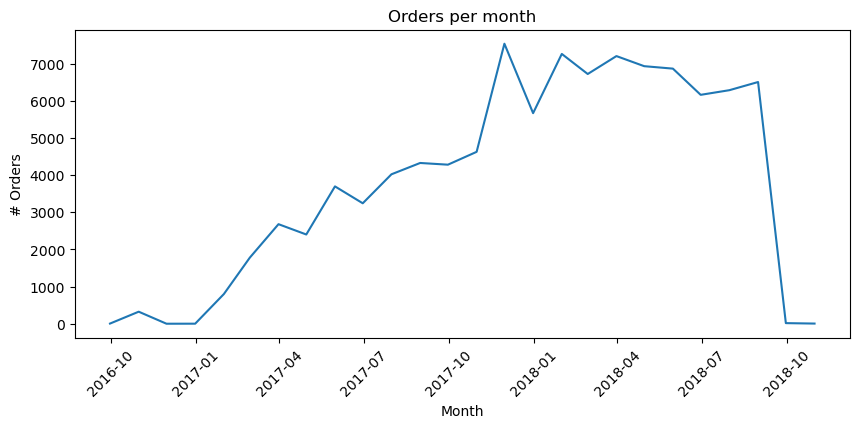

In [16]:
# Time series check: orders per month
orders_dt = orders.copy()
for c in ["order_purchase_timestamp", "order_approved_at", "order_delivered_customer_date", "order_estimated_delivery_date"]:
    if c in orders_dt.columns:
        orders_dt[c] = pd.to_datetime(orders_dt[c], errors="coerce")

monthly = (orders_dt
           .set_index("order_purchase_timestamp")
           .resample("ME")["order_id"]
           .count()
           .rename("orders_per_month")
          )

plt.figure(figsize=(10,4))
plt.plot(monthly.index, monthly.values)
plt.title("Orders per month")
plt.xlabel("Month")
plt.ylabel("# Orders")
plt.xticks(rotation=45)
plt.show()

### 4. Feature Engineering
- Created leakage-safe, order-level features using only information available at purchase time:
- pricing, freight, number of items/sellers
- payment information
- time-based features (day of week, hour of day)
- customer state
- Maintained a **canonical feature dataset** for analysis and splitting.
- Created a **Feature Store–compatible version** with strict data types.


In [ ]:
# Feature Engineering and Label Definition
orders_fe = orders_dt.copy()

reviews_fe = reviews.copy()
reviews_fe["review_score"] = pd.to_numeric(reviews_fe["review_score"], errors="coerce")

# Make an order-level review score
order_review = (reviews_fe
                .groupby("order_id", as_index=False)["review_score"]
                .mean()
                .rename(columns={"review_score": "review_score_mean"})
               )
order_review["label_satisfied"] = (order_review["review_score_mean"] >= 4).astype(int)

# Item aggregates
items_fe = items.copy()
items_fe["price"] = pd.to_numeric(items_fe["price"], errors="coerce")
items_fe["freight_value"] = pd.to_numeric(items_fe["freight_value"], errors="coerce")

item_agg = (items_fe
            .groupby("order_id", as_index=False)
            .agg(total_items=("order_item_id", "max"),
                 total_price=("price", "sum"),
                 total_freight=("freight_value", "sum"),
                 product_count_distinct=("product_id", "nunique"))
           )

# Payment aggregates
payments_fe = payments.copy()
payments_fe["payment_value"] = pd.to_numeric(payments_fe["payment_value"], errors="coerce")
payments_fe["payment_installments"] = pd.to_numeric(payments_fe["payment_installments"], errors="coerce")

pay_agg = (payments_fe
           .groupby("order_id", as_index=False)
           .agg(payment_value_sum=("payment_value", "sum"),
                payment_installments_max=("payment_installments", "max"),
                payment_types=("payment_type", lambda x: ",".join(sorted(set(map(str, x.dropna()))))))
          )

# Customer attributes
cust = customers[["customer_id", "customer_state"]].copy()

# Join to build feature frame
feat = (orders_fe
        .merge(order_review, on="order_id", how="inner")  
        .merge(item_agg, on="order_id", how="left")
        .merge(pay_agg, on="order_id", how="left")
        .merge(cust, on="customer_id", how="left")
       )

# Delivery features
feat["order_delivered_customer_date"] = pd.to_datetime(feat["order_delivered_customer_date"], errors="coerce")
feat["order_purchase_timestamp"] = pd.to_datetime(feat["order_purchase_timestamp"], errors="coerce")
feat["order_estimated_delivery_date"] = pd.to_datetime(feat["order_estimated_delivery_date"], errors="coerce")

feat["delivery_time_days"] = (feat["order_delivered_customer_date"] - feat["order_purchase_timestamp"]).dt.total_seconds() / (3600*24)
feat["estimated_time_days"] = (feat["order_estimated_delivery_date"] - feat["order_purchase_timestamp"]).dt.total_seconds() / (3600*24)
feat["delivered_late"] = (feat["order_delivered_customer_date"] > feat["order_estimated_delivery_date"]).astype("Int64")

# Clean / fill
num_cols = ["total_items","total_price","total_freight","payment_value_sum","payment_installments_max",
            "delivery_time_days","estimated_time_days"]
for c in num_cols:
    feat[c] = pd.to_numeric(feat[c], errors="coerce")
feat[num_cols] = feat[num_cols].fillna(feat[num_cols].median(numeric_only=True))

feat["customer_state"] = feat["customer_state"].fillna("UNK").astype(str)
feat["payment_types"] = feat["payment_types"].fillna("UNK").astype(str)

# Add event time + record identifier for Feature Store
feat = feat.reset_index(drop=True)
feat["event_time"] = feat["order_purchase_timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
feat = feat.dropna(subset=["event_time"])
feat["record_id"] = feat["order_id"].astype(str)

print("Engineered feature frame:", feat.shape)
feat.head()


Engineered feature frame: (98673, 23)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score_mean,label_satisfied,...,product_count_distinct,payment_value_sum,payment_installments_max,payment_types,customer_state,delivery_time_days,estimated_time_days,delivered_late,event_time,record_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,4.0,1,...,1.0,38.71,1.0,"credit_card,voucher",SP,8.436574,15.544063,0,2026-01-25T19:29:16Z,e481f51cbdc54678b7cc49136f2d6af7
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,4.0,1,...,1.0,141.46,1.0,boleto,BA,13.782037,19.137766,0,2026-01-25T19:29:16Z,53cdb2fc8bc7dce0b6741e2150273451
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,5.0,1,...,1.0,179.12,3.0,credit_card,GO,9.394213,26.639711,0,2026-01-25T19:29:16Z,47770eb9100c2d0c44946d9cf07ec65d
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,5.0,1,...,1.0,72.20,1.0,credit_card,RN,13.208750,26.188819,0,2026-01-25T19:29:16Z,949d5b44dbf5de918fe9c16f97b45f8a
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,5.0,1,...,1.0,28.62,1.0,credit_card,SP,2.873877,12.112049,0,2026-01-25T19:29:16Z,ad21c59c0840e6cb83a9ceb5573f8159


### Persist Features
Saving the engineered features to S3 in Parquet format.


In [18]:
# Save engineered features to S3 as parquet (efficient for Athena/ML)
FEATURE_S3_URI = f"s3://{DATALAKE_BUCKET}/{FEATURE_PREFIX}order_level_features/"
wr.s3.to_parquet(df=feat, path=FEATURE_S3_URI, dataset=True, mode="overwrite")
print("Wrote features to:", FEATURE_S3_URI)

# Optional: create Athena table over features
wr.catalog.create_parquet_table(
    database=ATHENA_DB,
    table="olist_order_level_features",
    path=FEATURE_S3_URI,
    columns_types={c: ("bigint" if str(feat[c].dtype).startswith("int") else
                       "double" if str(feat[c].dtype).startswith("float") else
                       "string")
                   for c in feat.columns},
    mode="overwrite"
)
print("Created/updated Athena table: olist_order_level_features")

Wrote features to: s3://sagemaker-us-east-1-638321960078/datalake/olist/features/order_level_features/
Created/updated Athena table: olist_order_level_features


### Note on Feature Store Timestamp Logic
**Engineering Decision**: For this project, we utilize `order_purchase_timestamp` as the canonical `event_time` for the Feature Store. This simplifies the pipeline by grouping all order-related attributes (including those that occur later, like `review_score` or `delivery_date`) into a single Feature Group.

**Trade-off**: In a strict real-time production inference scenario, this could introduce **data leakage** (Time Travel), as features unavailable at the moment of purchase (e.g., reviews) are indexed under the purchase time.
**Mitigation**: For a production system requiring point-in-time correctness, we would split feature groups by temporal availability (e.g., `features_at_purchase`, `features_at_delivery`) or use the latest timestamp in the row as the `event_time`.


### 5. SageMaker Feature Store (Offline Store)
- Created a **SageMaker Feature Group** (offline store only to control cost).
- Used `order_id` as the record identifier.
- Used a strictly formatted ISO-8601 `event_time` with UTC (`Z`) as the event time feature.
- Successfully ingested ~99k feature records into Feature Store.
- Offline store data is persisted in S3 for training and future reuse.


In [21]:
import pandas as pd

feat_fs = feat.copy()

# Detect datetime columns
datetime_cols = [c for c in feat_fs.columns if pd.api.types.is_datetime64_any_dtype(feat_fs[c])]
print("Datetime columns:", datetime_cols)

# Convert datetime columns to epoch seconds
for c in datetime_cols:
    feat_fs[c] = (
        pd.to_datetime(feat_fs[c], errors="coerce")
        .astype("int64") // 10**9
    )

# Ensure record_id + event_time formats
feat_fs["record_id"] = feat_fs["record_id"].astype(str)

# Feature Store expects event_time; keep it as ISO8601 string
feat_fs["event_time"] = (
    pd.to_datetime(feat_fs["event_time"], errors="coerce")
    .dt.strftime("%Y-%m-%dT%H:%M:%SZ")
)

# Normalize dtypes Feature Store accepts 
for c in feat_fs.columns:
    if str(feat_fs[c].dtype) in ("Int64", "int64"):
        feat_fs[c] = pd.to_numeric(feat_fs[c], errors="coerce").fillna(0).astype("int64")
    elif str(feat_fs[c].dtype) in ("Float64", "float64"):
        feat_fs[c] = pd.to_numeric(feat_fs[c], errors="coerce").astype("float64")
    else:
        # treat everything else as string
        feat_fs[c] = feat_fs[c].fillna("UNK").astype(str)

feat_fs.dtypes



Datetime columns: ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date']


order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp           int64
order_approved_at                  int64
order_delivered_carrier_date      object
order_delivered_customer_date      int64
order_estimated_delivery_date      int64
review_score_mean                float64
label_satisfied                    int64
total_items                      float64
total_price                      float64
total_freight                    float64
product_count_distinct           float64
payment_value_sum                float64
payment_installments_max         float64
payment_types                     object
customer_state                    object
delivery_time_days               float64
estimated_time_days              float64
delivered_late                     int64
event_time                        object
record_id                         object
dtype: object

### Configuration
Setting up SageMaker session, default bucket, and S3 prefixes.


In [23]:
import time
import sagemaker
from sagemaker.feature_store.feature_group import FeatureGroup
from botocore.exceptions import ClientError

sm_sess = sagemaker.Session()
role = sagemaker.get_execution_role()

# STATIC NAME for budget safety (idempotent)
FG_NAME = "olist-order-features-v2"

offline_prefix = f"feature-store/olist/{FG_NAME}/"
offline_s3_uri = f"s3://{DATALAKE_BUCKET}/{offline_prefix}"

print("Feature Group:", FG_NAME)
print("Offline store:", offline_s3_uri)
print("Role:", role)

fg = FeatureGroup(name=FG_NAME, sagemaker_session=sm_sess)
fg.load_feature_definitions(data_frame=feat_fs)

def wait_for_fg_creation(fg_obj):
    for i in range(60):
        status = fg_obj.describe().get("FeatureGroupStatus")
        print(f"[{i+1}/60] Status:", status)
        if status in ("Created", "CreateFailed"):
            break
        time.sleep(5)
    if status != "Created":
        raise RuntimeError(f"Feature Group failed: {status}")

try:
    # Describe first to see if it exists
    fg.describe()
    print(f"✅ Feature Group '{FG_NAME}' already exists. Skipping creation.")
except ClientError as e:
    if "ResourceNotFound" in str(e):
        print("Creating Feature Group...")
        fg.create(
            s3_uri=offline_s3_uri,
            record_identifier_name="record_id",
            event_time_feature_name="event_time",
            role_arn=role,
            enable_online_store=False,
        )
        wait_for_fg_creation(fg)
        print("✅ Feature Group created successfully.")
    else:
        raise


Feature Group: olist-order-features-1769370404
Offline store: s3://sagemaker-us-east-1-638321960078/feature-store/olist/olist-order-features-1769370404/
Role: arn:aws:iam::638321960078:role/LabRole
Create request sent. Waiting for Feature Group to become 'Created'...
[1/60] Status: Creating
[2/60] Status: Creating
[3/60] Status: Created
Final status: Created


### Ingest Data
Ingesting feature records into the Feature Store (Offline Store).


In [27]:
# Chunked ingestion to avoid kernel termination
import math
import time

try:
    status = fg.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Feature Group not in Created state: {status}")

    df = feat_fs.reset_index(drop=True)

    CHUNK = 5000   
    n = len(df)
    n_chunks = math.ceil(n / CHUNK)

    print(f"Submitting ingestion in {n_chunks} chunks of {CHUNK} rows...")

    for i in range(n_chunks):
        start = i * CHUNK
        end = min((i + 1) * CHUNK, n)
        chunk_df = df.iloc[start:end].copy()

        # Submit chunk (async)
        fg.ingest(data_frame=chunk_df, max_workers=3)

        print(f"Submitted chunk {i+1}/{n_chunks}: rows {start}-{end-1}")
        time.sleep(1)  

    print("All chunks submitted. Offline store files will appear in S3 shortly.")

except Exception as e:
    print("Chunked ingestion failed:", repr(e))



Submitting ingestion in 20 chunks of 5000 rows...
Submitted chunk 1/20: rows 0-4999
Submitted chunk 2/20: rows 5000-9999
Submitted chunk 3/20: rows 10000-14999
Submitted chunk 4/20: rows 15000-19999
Submitted chunk 5/20: rows 20000-24999
Submitted chunk 6/20: rows 25000-29999
Submitted chunk 7/20: rows 30000-34999
Submitted chunk 8/20: rows 35000-39999
Submitted chunk 9/20: rows 40000-44999
Submitted chunk 10/20: rows 45000-49999
Submitted chunk 11/20: rows 50000-54999
Submitted chunk 12/20: rows 55000-59999
Submitted chunk 13/20: rows 60000-64999
Submitted chunk 14/20: rows 65000-69999
Submitted chunk 15/20: rows 70000-74999
Submitted chunk 16/20: rows 75000-79999
Submitted chunk 17/20: rows 80000-84999
Submitted chunk 18/20: rows 85000-89999
Submitted chunk 19/20: rows 90000-94999
Submitted chunk 20/20: rows 95000-98672
All chunks submitted. Offline store files will appear in S3 shortly.


### 6. Dataset Splitting (Time-Based)
- Performed a **time-based split** using `event_time` to avoid temporal leakage:
- Train: ~40%
- Validation: ~10%
- Test: ~10%
- Production reserve: ~40%
- Persisted each split as Parquet files to: s3:///splits/olist/features/version=v1/
- This mirrors a real production setup where recent data is reserved for inference.


In [28]:
# Sort by time to prevent leakage (Time-Series Split)
df = feat.sort_values(by="order_purchase_timestamp").reset_index(drop=True).copy()

n = len(df)
train_end = int(n * 0.40)           # 40%
test_end = int(n * 0.50)            # 10%
val_end = int(n * 0.60)             # 10%
# Remaining 40% is production

df_train = df.iloc[:train_end]
df_test = df.iloc[train_end:test_end]
df_val = df.iloc[test_end:val_end]
df_prod = df.iloc[val_end:]

print("Total:", len(df))
print("Train:", len(df_train), f"({len(df_train)/len(df):.1%})")
print("Test :", len(df_test),  f"({len(df_test)/len(df):.1%})")
print("Val  :", len(df_val),   f"({len(df_val)/len(df):.1%})")
print("Prod :", len(df_prod),  f"({len(df_prod)/len(df):.1%})")

# Save to S3
base = f"s3://{DATALAKE_BUCKET}/{SPLITS_PREFIX}order_level/"
paths = {
    "train": base + "train/",
    "test": base + "test/",
    "val": base + "val/",
    "prod": base + "prod/",
}

wr.s3.to_parquet(df=df_train, path=paths["train"], dataset=True, mode="overwrite")
wr.s3.to_parquet(df=df_test,  path=paths["test"],  dataset=True, mode="overwrite")
wr.s3.to_parquet(df=df_val,   path=paths["val"],   dataset=True, mode="overwrite")
wr.s3.to_parquet(df=df_prod,  path=paths["prod"],  dataset=True, mode="overwrite")

print("Saved splits under:", base)


Total: 98673
Train: 39468 (40.0%)
Test : 9867 (10.0%)
Val  : 9868 (10.0%)
Prod : 39470 (40.0%)
Saved splits under: s3://sagemaker-us-east-1-638321960078/datalake/olist/splits/order_level/
